In [ ]:
# Mount "My Drive" into /content/drive
from google.colab import drive

google_drive_dir = "Final_project"  # @param
#bml-notebooks/
drive.mount('/content/drive')

mount_point = "/content/drive/My Drive/{}".format(google_drive_dir)

# Change the root directory to your mount_point
% cd '$mount_point'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Final_project


# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [ ]:
import numpy as np
from src.loadData import loadFer2013
from keras.utils import to_categorical


In [ ]:
X_train,X_val,X_test,y_train,y_val,y_test = loadFer2013('fer2013/icml_face_data.csv')

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

/content/drive/My Drive/Final_project/src/loadData.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['emotion'][data['emotion']>1]-=1


In [ ]:
y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((28709, 6), (3589, 6), (3589, 6))

In [ ]:
X_train.shape, y_train.shape

((28709, 48, 48), (28709,))

In [ ]:
emotions = {0: 'Angry', 1:'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}

In [ ]:
class_names = list(emotions.values())
class_names

['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#Preprocessing

In [ ]:
def preprocessX(X):
    X = np.expand_dims(X,axis=-1)
    return X/255

X_processed_train = preprocessX(X_train)
X_processed_val = preprocessX(X_val)
X_processed_test = preprocessX(X_test)
X_processed_train.shape,X_processed_val.shape,X_processed_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1), (3589, 48, 48, 1))

# Extract features

In [ ]:
from keras import models, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

#Load pretrain model


In [ ]:
from keras.models import model_from_json

json_file = open('keras_model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("keras_model/model.h5")

In [ ]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [ ]:
y_pred = loaded_model.predict(X_processed_test)

In [ ]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred.argmax(axis=1)))
print(metrics.f1_score(y_test, y_pred.argmax(axis=1),average='micro'))

0.5564224017832266
0.5564224017832266


In [ ]:
extract = Model(loaded_model.inputs, loaded_model.layers[-3].output) # Dense(128,...)


In [ ]:
test_features = extract(X_processed_test)

#Classify

In [ ]:
from sklearn.svm import SVC
import time
svm=SVC(kernel='rbf', class_weight='balanced',C=1)
st = time.time()
svm.fit(features, y_train)
print(time.time()-st)
svm.score(features, y_train)

5105.537826299667


0.8360792782751054

In [ ]:
import pickle
pickle.dump(svm, open('saved_model/CNN_svmC1.pkl', 'wb'))

In [ ]:
import pickle
svm = pickle.load(open('saved_model/CNN_svmC1.pkl', 'rb'))

In [ ]:
test_features = extract(X_processed_test)
y_pred = svm.predict(test_features)


In [ ]:
y_pred

array([0, 5, 0, ..., 3, 0, 5])

In [ ]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred,average='micro'))


0.593201448871552
0.593201448871552


#Evaluation

              precision    recall  f1-score   support

       Angry       0.46      0.54      0.50       467
        Fear       0.50      0.38      0.43       552
       Happy       0.82      0.75      0.78       895
         Sad       0.48      0.50      0.49       653
    Surprise       0.73      0.77      0.75       415
     Neutral       0.50      0.59      0.54       607

    accuracy                           0.59      3589
   macro avg       0.58      0.59      0.58      3589
weighted avg       0.60      0.59      0.59      3589



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f26c2ae3240>)

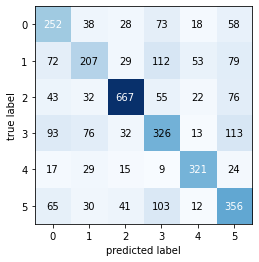

In [ ]:
# Quantitative evaluation of the model quality on the test set
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print(classification_report(y_test, y_pred, target_names=class_names))
plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=range(len(class_names))))